**1a Comparação**

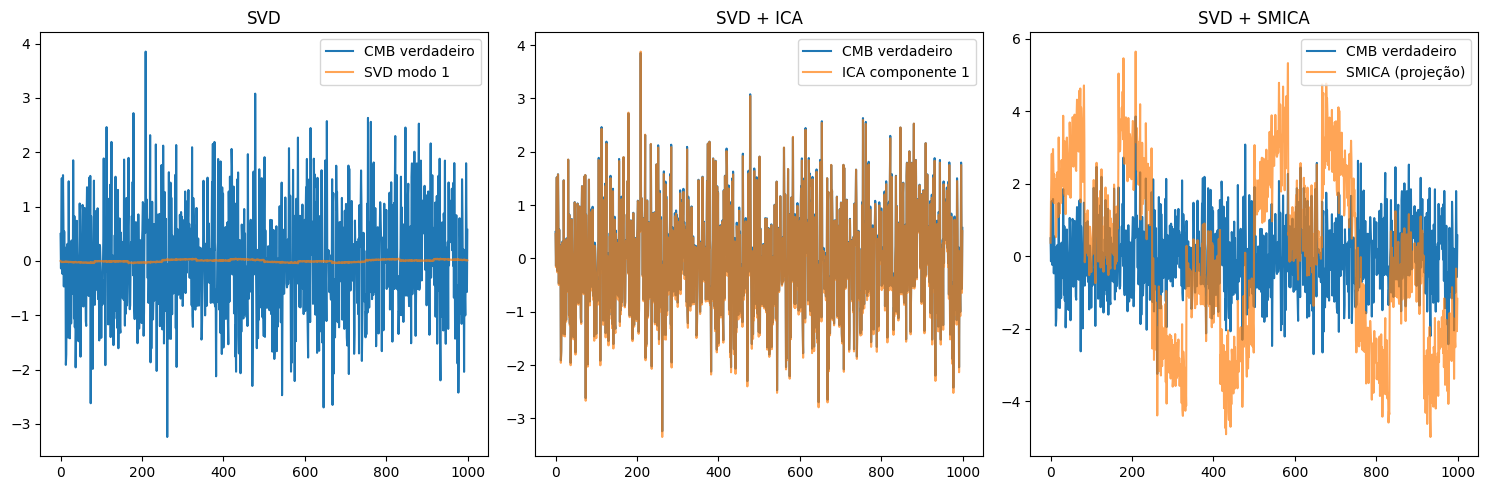

In [17]:
# Comparando métodos: SVD, SVD + ICA, SVD + SMICA para isolar a CMB
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# ---------------------------
# Simula dados multiespectrais
# ---------------------------
np.random.seed(42)
n_pixels = 2000
n_channels = 5
n_sources = 3
t = np.linspace(0, 8 * np.pi, n_pixels)

# Fontes verdadeiras
cmb = np.random.normal(0, 1, n_pixels)
fg1 = 2 * np.sin(t)
fg2 = 1.5 * np.sign(np.sin(3 * t))
sources = np.vstack([cmb, fg1, fg2])  # shape (3, n_pixels)

# Mistura linear
mixing = np.random.rand(n_channels, n_sources)
X = mixing @ sources  # shape (5, 2000)
# ---------------------------
# 1. SVD
# ---------------------------
U, s, Vt = np.linalg.svd(X, full_matrices=False)
svd_mode1 = Vt[0]  # Primeiro modo principal

# ---------------------------
# 2. SVD + ICA
# ---------------------------
X_reduced = U[:, :3].T @ X  # Projeção para os 3 primeiros modos
ica = FastICA(n_components=3, random_state=42)
S_ica = ica.fit_transform(X_reduced.T).T  # (3, 2000)

# ---------------------------
# 3. SVD + SMICA (projeção espectral conhecida)
# ---------------------------
cmb_spectrum = np.ones(n_channels)
cmb_spectrum /= np.linalg.norm(cmb_spectrum)
cmb_estimate = cmb_spectrum @ X  # shape (2000,)

# ---------------------------
# Visualização comparativa
# ---------------------------
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(cmb[:1000], label="CMB verdadeiro")
plt.plot(svd_mode1[:1000], label="SVD modo 1", alpha=0.7)
plt.title("SVD")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(cmb[:1000], label="CMB verdadeiro")
plt.plot(S_ica[0, :1000], label="ICA componente 1", alpha=0.7)
plt.title("SVD + ICA")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(cmb[:1000], label="CMB verdadeiro")
plt.plot(cmb_estimate[:1000], label="SMICA (projeção)", alpha=0.7)
plt.title("SVD + SMICA")
plt.legend()

plt.tight_layout()
plt.show()


**Testes SMICA**

Melhor correlação: componente 1, correlação = 0.053


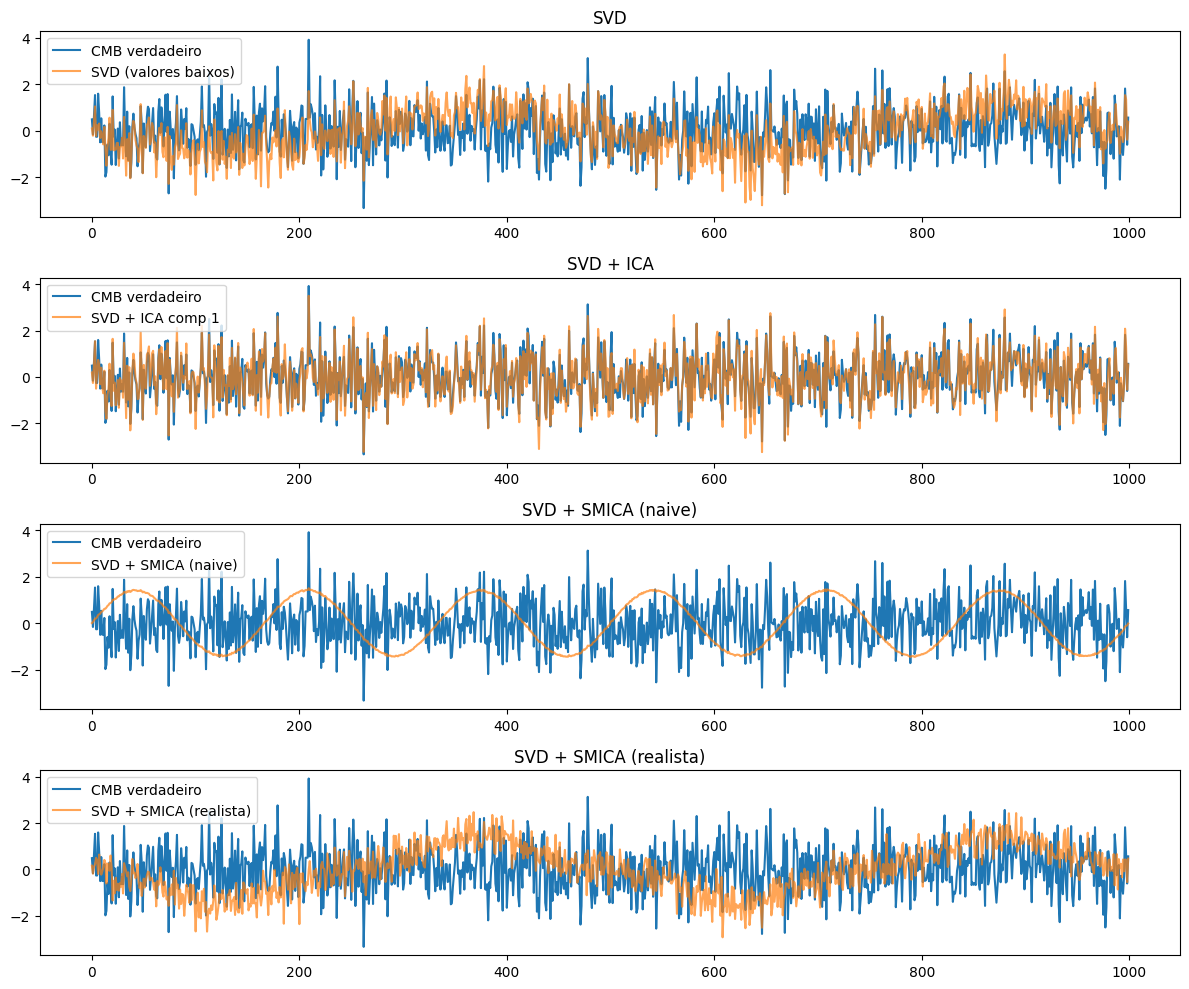

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# ==================== SIMULAÇÃO DOS DADOS ====================
np.random.seed(42)
n_pixels = 2000
n_channels = 5
t = np.linspace(0, 8 * np.pi, n_pixels)

# Componentes simuladas
cmb = np.random.normal(0, 1, n_pixels)
sync = 2 * np.sin(t)
dust = 1.5 * np.sin(3 * t)
sources = np.vstack([cmb, sync, dust])  # (3, n_pixels)

# Espectros de emissão
freqs = np.linspace(30, 300, n_channels)
cmb_spec = np.ones(n_channels)
sync_spec = (freqs / freqs[0]) ** -1.2
dust_spec = (freqs / freqs[0]) ** 2.0
A_true = np.vstack([cmb_spec, sync_spec, dust_spec]).T  # (n_channels, 3)

# Mistura linear + ruído
X_clean = A_true @ sources  # (n_channels, n_pixels)
# Níveis de ruído diferentes por canal (simulando diferentes sensibilidades)
noise_levels = np.array([0.3, 0.35, 0.4, 0.45, 0.5])  # um valor por canal
noise = np.random.normal(scale=noise_levels[:, None], size=X_clean.shape)


# ==================== MÉTODO 1: SVD-only ====================
U, s, Vt = np.linalg.svd(X, full_matrices=False)
svd_filtered = np.sum((s[2:] * Vt[2:].T) @ U[:, 2:].T, axis=1)

# ==================== MÉTODO 2: SVD + ICA ====================
X_reduced = U[:, :3].T @ X
ica = FastICA(n_components=3, random_state=42)
S_ica = ica.fit_transform(X_reduced.T).T
ica_candidate = S_ica[0]

# ==================== MÉTODO 3: SVD + SMICA naive ====================
cmb_spec_flat = np.ones(n_channels)
cmb_spec_flat /= np.linalg.norm(cmb_spec_flat)
cmb_proj_naive = cmb_spec_flat @ X

# ==================== MÉTODO 4: SVD + SMICA realista ====================
def smica_1d_updateA(X, ncomp=3, n_bins=15, max_iter=50, tol=1e-6, lr=0.01):
    n_channels, n_pixels = X.shape
    X_fft = np.fft.fft(X, axis=1)
    freqs = np.fft.fftfreq(n_pixels)
    pos_mask = freqs >= 0
    freqs_pos = freqs[pos_mask]
    bins = np.linspace(0, freqs_pos.max(), n_bins+1)

    # Estimar matrizes de covariância por bin
    covs = []
    for i in range(n_bins):
        mask = (freqs_pos >= bins[i]) & (freqs_pos < bins[i+1])
        if np.sum(mask) == 0:
            covs.append(np.zeros((n_channels, n_channels)))
            continue
        X_bin = X_fft[:, pos_mask][:, mask]
        cov = np.zeros((n_channels, n_channels), dtype=np.complex128)
        for c1 in range(n_channels):
            for c2 in range(n_channels):
                cov[c1, c2] = np.mean(X_bin[c1] * np.conj(X_bin[c2]))
        covs.append(cov.real)
    covs = np.array(covs)

    # Inicialização
    np.random.seed(0)
    A = np.random.randn(n_channels, ncomp)
    for i in range(ncomp):
        A[:, i] /= np.linalg.norm(A[:, i])
    R = np.ones((n_bins, ncomp))

    def cost(covs, A, R):
        total = 0
        for b in range(n_bins):
            Rb = np.diag(R[b])
            Sigma = A @ Rb @ A.T
            try:
                inv_Sigma = np.linalg.inv(Sigma)
                sign, logdet = np.linalg.slogdet(Sigma)
            except np.linalg.LinAlgError:
                return np.inf
            if sign <= 0:
                return np.inf
            total += logdet + np.trace(inv_Sigma @ covs[b])
        return total

    prev = np.inf
    for it in range(max_iter):
        # Atualiza R
        for b in range(n_bins):
            inv_cov = np.linalg.pinv(covs[b] + 1e-6*np.eye(n_channels))
            for comp in range(ncomp):
                a = A[:, comp][:, None]
                numerator = (a.T @ inv_cov @ a)[0,0]
                denominator = (a.T @ a) ** 2
                R[b, comp] = max((numerator / denominator).item(), 1e-6)  # Corrigido

        # Gradiente para A
        grad = np.zeros_like(A)
        for b in range(n_bins):
            Rb = np.diag(R[b])
            Sigma = A @ Rb @ A.T
            inv_Sigma = np.linalg.pinv(Sigma + 1e-6 * np.eye(n_channels))  # Corrigido
            diff = inv_Sigma - inv_Sigma @ covs[b] @ inv_Sigma
            grad += 2 * diff @ A @ Rb

        A -= lr * grad
        for i in range(ncomp):
            A[:, i] /= np.linalg.norm(A[:, i])

        c = cost(covs, A, R)
        if abs(prev - c) < tol:
            break
        prev = c

    A_pinv = np.linalg.pinv(A)
    S_est = A_pinv @ X
    return S_est


S_est = smica_1d_updateA(X, ncomp=3, n_bins=15, max_iter=100, lr=0.001)

# Seleciona a componente mais correlacionada com a CMB
from scipy.stats import pearsonr
corrs = [abs(pearsonr(cmb, S_est[i])[0]) for i in range(3)]
best_idx = np.argmax(corrs)
cmb_proj_realistic = S_est[best_idx]

print(f"Melhor correlação: componente {best_idx}, correlação = {corrs[best_idx]:.3f}")
  # componente 0

# ==================== PLOT COMPARATIVO ====================
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(svd_filtered[:1000]), label="SVD (valores baixos)", alpha=0.7)
plt.legend(); plt.title("SVD")

plt.subplot(4, 1, 2)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(ica_candidate[:1000]), label="SVD + ICA comp 1", alpha=0.7)
plt.legend(); plt.title("SVD + ICA")

plt.subplot(4, 1, 3)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(cmb_proj_naive[:1000]), label="SVD + SMICA (naive)", alpha=0.7)
plt.legend(); plt.title("SVD + SMICA (naive)")

plt.subplot(4, 1, 4)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(cmb_proj_realistic[:1000]), label="SVD + SMICA (realista)", alpha=0.7)
plt.legend(); plt.title("SVD + SMICA (realista)")

plt.tight_layout()
plt.show()


In [35]:
from scipy.stats import pearsonr
corr = pearsonr(cmb, cmb_proj_realistic)[0]
print(f"Correlação CMB x SMICA realista: {corr:.3f}")


Correlação CMB x SMICA realista: -0.052


Text(0.5, 1.0, 'Componentes separadas via SMICA')

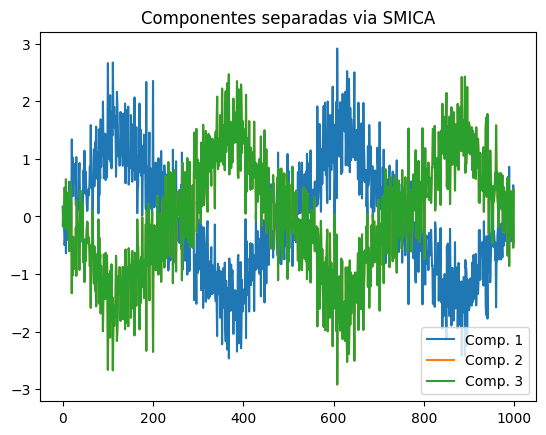

In [36]:
S_est = smica_1d_updateA(X, ncomp=3, n_bins=15, max_iter=100, lr=0.001)
for i in range(3):
    plt.plot(normalize(S_est[i, :1000]), label=f"Comp. {i+1}")
plt.legend(); plt.title("Componentes separadas via SMICA")


Seleciona a componente mais parecida com a cmd

Componente mais correlacionada com a CMB: índice 1, correlação = 0.053


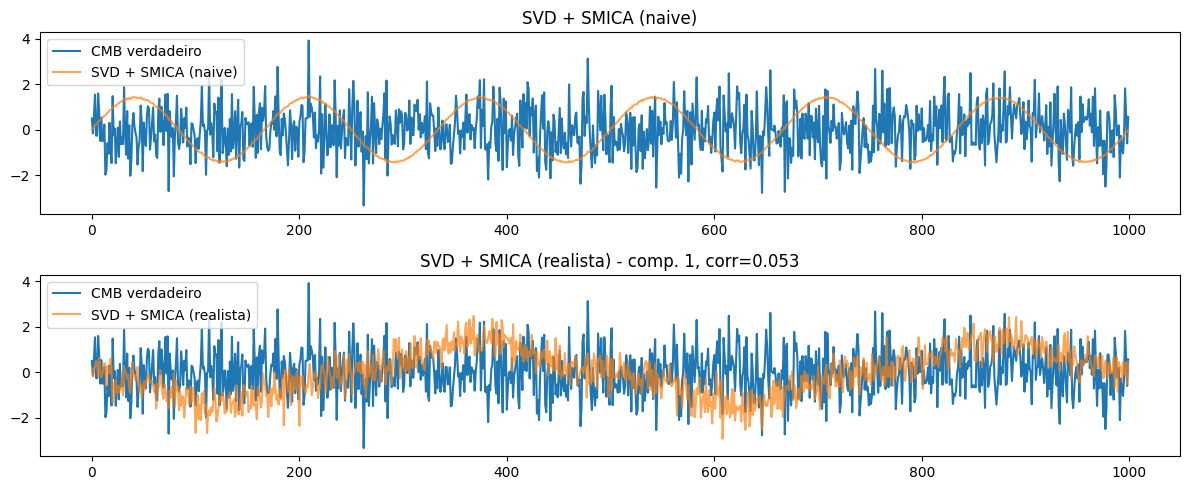

In [28]:
from scipy.stats import pearsonr

# === Rodar SMICA realista (com 3 componentes)
S_est = smica_1d_updateA(X, ncomp=3, n_bins=15, max_iter=100, lr=0.001)

# === Selecionar a componente mais parecida com a CMB
best_idx = np.argmax([abs(pearsonr(cmb, S_est[i])[0]) for i in range(3)])
best_corr = pearsonr(cmb, S_est[best_idx])[0]
cmb_proj_realistic = S_est[best_idx]

print(f"Componente mais correlacionada com a CMB: índice {best_idx}, correlação = {best_corr:.3f}")


plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(cmb_proj_naive[:1000]), label="SVD + SMICA (naive)", alpha=0.7)
plt.legend(); plt.title("SVD + SMICA (naive)")

plt.subplot(2, 1, 2)
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(cmb_proj_realistic[:1000]), label="SVD + SMICA (realista)", alpha=0.7)
plt.legend(); plt.title(f"SVD + SMICA (realista) - comp. {best_idx}, corr={best_corr:.3f}")

plt.tight_layout()
plt.show()


**Simulando SMICA com mais parâmetros (sem SVD)**

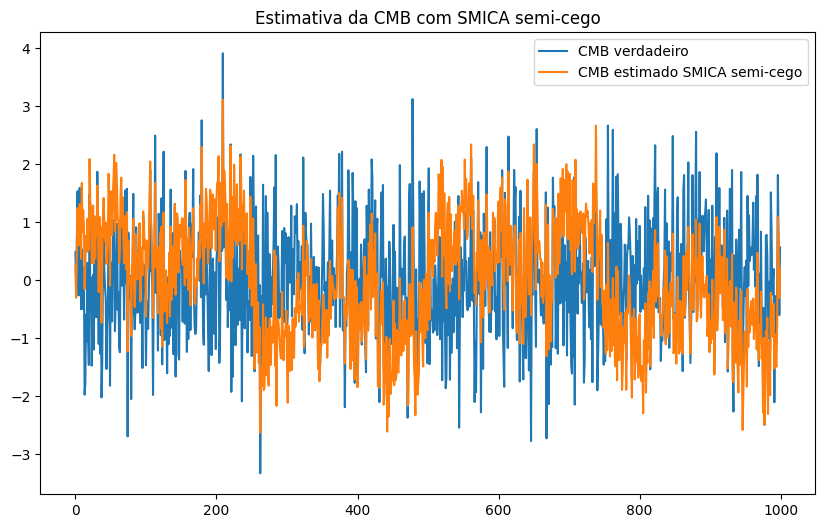

In [31]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)
n_pixels = 2000
n_channels = 9  # mais bandas
n_components = 6  # mais componentes físicas

# Frequências simuladas (em GHz)
freqs = np.linspace(30, 300, n_channels)

# Definir espectros físicos aproximados (normalizados)
cmb_spec = np.ones(n_channels)  # CMB plano (unidades termodinâmicas)

sync_spec = (freqs / freqs[0]) ** -1.2  # Síncrotron
dust_spec = (freqs / freqs[0]) ** 2.0   # Poeira
sz_spec = freqs * np.exp(-freqs / 100)  # Exemplo simplificado SZ
co_spec = np.exp(-((freqs - 115) ** 2) / (2 * 10 ** 2))  # Pico em 115 GHz CO
freefree_spec = (freqs / freqs[0]) ** -0.15  # Emissão free-free

# Normalizar espectros para magnitude ~1
def norm(v): return v / np.linalg.norm(v)
specs = np.vstack([cmb_spec, sync_spec, dust_spec, sz_spec, co_spec, freefree_spec])
specs = np.array([norm(s) for s in specs])

# Gerar componentes simuladas no tempo/espaço
t = np.linspace(0, 8 * np.pi, n_pixels)
cmb = np.random.normal(0, 1, n_pixels)
sync = 2 * np.sin(t)
dust = 1.5 * np.sin(3 * t)
sz = 0.5 * np.sin(5 * t)
co = 0.3 * np.sin(7 * t)
freefree = 0.7 * np.sin(11 * t)
sources = np.vstack([cmb, sync, dust, sz, co, freefree])

# Mistura linear
X_clean = specs.T @ sources  # shape (n_channels, n_pixels)

# Ruído
noise_levels = np.linspace(0.25, 0.5, n_channels)
noise = np.random.normal(scale=noise_levels[:, None], size=X_clean.shape)
X = X_clean + noise

# SMICA semi-cego: fixa coluna 0 (CMB) da matriz A para o vetor cmb_spec
def smica_semi_blind(X, specs, fixed_indices=[0], max_iter=100, tol=1e-6, lr=0.001, reg=1e-3):
    n_channels, n_pixels = X.shape
    ncomp = specs.shape[0]
    n_bins = 15

    X_fft = np.fft.fft(X, axis=1)
    freqs_fft = np.fft.fftfreq(n_pixels)
    pos_mask = freqs_fft >= 0
    freqs_pos = freqs_fft[pos_mask]
    bins = np.linspace(0, freqs_pos.max(), n_bins+1)

    # Covariância por bin
    covs = []
    for i in range(n_bins):
        mask = (freqs_pos >= bins[i]) & (freqs_pos < bins[i+1])
        if np.sum(mask) == 0:
            covs.append(np.zeros((n_channels, n_channels)))
            continue
        X_bin = X_fft[:, pos_mask][:, mask]
        cov = np.zeros((n_channels, n_channels), dtype=np.complex128)
        for c1 in range(n_channels):
            for c2 in range(n_channels):
                cov[c1, c2] = np.mean(X_bin[c1] * np.conj(X_bin[c2]))
        covs.append(cov.real)
    covs = np.array(covs)

    # Inicializa A, já fixando colunas conhecidas
    np.random.seed(0)
    A = np.random.randn(n_channels, ncomp)
    for i in range(ncomp):
        A[:, i] /= np.linalg.norm(A[:, i])
    # Impor espectros fixos nas colunas indicadas
    for idx in fixed_indices:
        A[:, idx] = specs[idx]
        A[:, idx] /= np.linalg.norm(A[:, idx])

    R = np.ones((n_bins, ncomp))

    def cost(covs, A, R):
        total = 0
        for b in range(n_bins):
            Rb = np.diag(R[b])
            Sigma = A @ Rb @ A.T
            try:
                inv_Sigma = np.linalg.inv(Sigma)
                sign, logdet = np.linalg.slogdet(Sigma)
            except np.linalg.LinAlgError:
                return np.inf
            if sign <= 0:
                return np.inf
            total += logdet + np.trace(inv_Sigma @ covs[b])
        return total

    prev = np.inf
    for it in range(max_iter):
        # Atualiza R
        for b in range(n_bins):
            inv_cov = np.linalg.pinv(covs[b] + 1e-6*np.eye(n_channels))
            for comp in range(ncomp):
                a = A[:, comp][:, None]
                numerator = (a.T @ inv_cov @ a)[0,0]
                denominator = (a.T @ a) ** 2
                R[b, comp] = max((numerator / denominator).item(), 1e-6)

        # Gradiente para A
        grad = np.zeros_like(A)
        for b in range(n_bins):
            Rb = np.diag(R[b])
            Sigma = A @ Rb @ A.T
            inv_Sigma = np.linalg.pinv(Sigma + 1e-6 * np.eye(n_channels))
            diff = inv_Sigma - inv_Sigma @ covs[b] @ inv_Sigma
            grad += 2 * diff @ A @ Rb

        # Aplica regularização para estabilidade
        grad += reg * A

        # Atualiza A apenas nas colunas que não estão fixas
        for i in range(ncomp):
            if i in fixed_indices:
                continue
            A[:, i] -= lr * grad[:, i]
            A[:, i] /= np.linalg.norm(A[:, i])

        c = cost(covs, A, R)
        if abs(prev - c) < tol:
            break
        prev = c

    # Reconstrução das fontes estimadas
    A_pinv = np.linalg.pinv(A)
    S_est = A_pinv @ X
    return S_est, A, R

S_est, A_est, R_est = smica_semi_blind(X, specs, fixed_indices=[0], max_iter=200, lr=0.001)

# Plot comparativo só para a CMB (fonte 0) estimada
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

plt.figure(figsize=(10,6))
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(S_est[0, :1000]), label="CMB estimado SMICA semi-cego")
plt.legend()
plt.title("Estimativa da CMB com SMICA semi-cego")
plt.show()


**Com SVD**

Melhor componente: 0, correlação = 0.007
Componente mais parecida com CMB: 2, correlação = 0.343


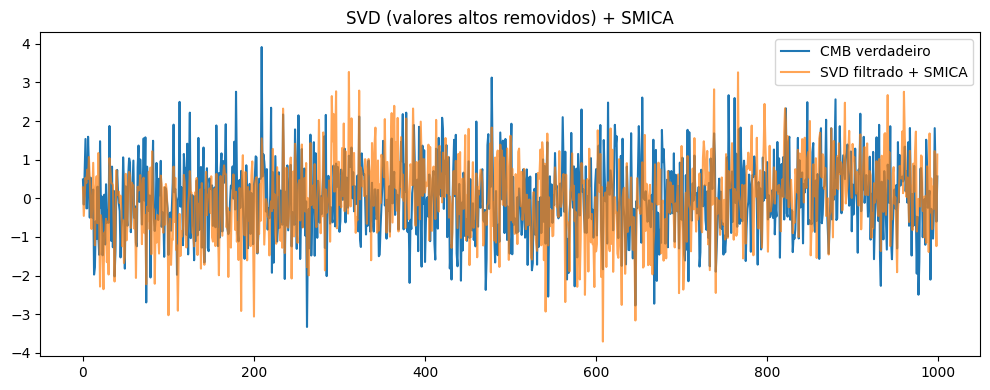

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def svd_filtered_smica(X, remove_k=2, ncomp=3, n_bins=15, max_iter=100, tol=1e-6, lr=0.001):
    # ===== SVD =====
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    
    # Elimina os k maiores valores singulares
    s_filtered = s.copy()
    s_filtered[:remove_k] = 0  # Zera os k primeiros
    S_mat = np.diag(s_filtered)
    
    # Reconstrói X filtrado
    X_filtered = U @ S_mat @ Vt

    # ===== SMICA no X filtrado =====
    S_est = smica_1d_updateA(X_filtered, ncomp=ncomp, n_bins=n_bins, max_iter=max_iter, tol=tol, lr=lr)

    return S_est


# Função auxiliar: normaliza vetor
def normalize(x):
    return (x - np.mean(x)) / np.std(x)

# ==================== SVD + SMICA ====================
def svd_plus_smica(X, ncomp=3, n_bins=15, max_iter=100, tol=1e-6, lr=0.001):
    n_channels, n_pixels = X.shape

    # ===== SVD: Redução dimensional =====
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    X_reduced = U[:, :ncomp].T @ X  # (ncomp, n_pixels)

    # ===== SMICA no espaço reduzido =====
    def smica_reduced(X_r, ncomp, n_bins, max_iter, tol, lr):
        X_fft = np.fft.fft(X_r, axis=1)
        freqs = np.fft.fftfreq(n_pixels)
        pos_mask = freqs >= 0
        freqs_pos = freqs[pos_mask]
        bins = np.linspace(0, freqs_pos.max(), n_bins+1)

        covs = []
        for i in range(n_bins):
            mask = (freqs_pos >= bins[i]) & (freqs_pos < bins[i+1])
            if np.sum(mask) == 0:
                covs.append(np.zeros((ncomp, ncomp)))
                continue
            X_bin = X_fft[:, pos_mask][:, mask]
            cov = np.zeros((ncomp, ncomp), dtype=np.complex128)
            for c1 in range(ncomp):
                for c2 in range(ncomp):
                    cov[c1, c2] = np.mean(X_bin[c1] * np.conj(X_bin[c2]))
            covs.append(cov.real)
        covs = np.array(covs)

        np.random.seed(0)
        A = np.random.randn(ncomp, ncomp)
        for i in range(ncomp):
            A[:, i] /= np.linalg.norm(A[:, i])
        R = np.ones((n_bins, ncomp))

        def cost(covs, A, R):
            total = 0
            for b in range(n_bins):
                Rb = np.diag(R[b])
                Sigma = A @ Rb @ A.T
                try:
                    inv_Sigma = np.linalg.inv(Sigma)
                    sign, logdet = np.linalg.slogdet(Sigma)
                except np.linalg.LinAlgError:
                    return np.inf
                if sign <= 0:
                    return np.inf
                total += logdet + np.trace(inv_Sigma @ covs[b])
            return total

        prev = np.inf
        for it in range(max_iter):
            for b in range(n_bins):
                inv_cov = np.linalg.pinv(covs[b] + 1e-6*np.eye(ncomp))
                for comp in range(ncomp):
                    a = A[:, comp][:, None]
                    numerator = (a.T @ inv_cov @ a)[0,0]
                    denominator = (a.T @ a) ** 2
                    R[b, comp] = max((numerator / denominator).item(), 1e-6)

            grad = np.zeros_like(A)
            for b in range(n_bins):
                Rb = np.diag(R[b])
                Sigma = A @ Rb @ A.T
                inv_Sigma = np.linalg.pinv(Sigma + 1e-6*np.eye(ncomp))
                diff = inv_Sigma - inv_Sigma @ covs[b] @ inv_Sigma
                grad += 2 * diff @ A @ Rb

            A -= lr * grad
            for i in range(ncomp):
                A[:, i] /= np.linalg.norm(A[:, i])

            c = cost(covs, A, R)
            if abs(prev - c) < tol:
                break
            prev = c

        A_pinv = np.linalg.pinv(A)
        S_est = A_pinv @ X_r
        return S_est

    S_est_reduced = smica_reduced(X_reduced, ncomp, n_bins, max_iter, tol, lr)

    # Reconstrução aproximada no espaço original (opcional)
    return S_est_reduced

# ==================== TESTE COM CMB ====================
# Simulação do dado misturado
np.random.seed(42)
n_pixels = 2000
n_channels = 5
t = np.linspace(0, 8 * np.pi, n_pixels)

cmb = np.random.normal(0, 1, n_pixels)
sync = 2 * np.sin(t)
dust = 1.5 * np.sin(3 * t)
sources = np.vstack([cmb, sync, dust])

freqs = np.linspace(30, 300, n_channels)
cmb_spec = np.ones(n_channels)
sync_spec = (freqs / freqs[0]) ** -1.2
dust_spec = (freqs / freqs[0]) ** 2.0
A_true = np.vstack([cmb_spec, sync_spec, dust_spec]).T

X_clean = A_true @ sources
noise_levels = np.array([0.3, 0.35, 0.4, 0.45, 0.5])
noise = np.random.normal(scale=noise_levels[:, None], size=X_clean.shape)
X = X_clean + noise

# Aplica SVD + SMICA
S_est = svd_plus_smica(X, ncomp=3)

# Escolhe componente mais parecida com a CMB
corrs = [abs(pearsonr(cmb, S_est[i])[0]) for i in range(3)]
best_idx = np.argmax(corrs)
cmb_est = S_est[best_idx]

print(f"Melhor componente: {best_idx}, correlação = {corrs[best_idx]:.3f}")

# Aplica SVD eliminando os 2 maiores modos
S_est = svd_filtered_smica(X, remove_k=2, ncomp=3)

# Seleciona a componente mais correlacionada com a CMB
corrs = [abs(pearsonr(cmb, S_est[i])[0]) for i in range(3)]
best_idx = np.argmax(corrs)
cmb_est = S_est[best_idx]

print(f"Componente mais parecida com CMB: {best_idx}, correlação = {corrs[best_idx]:.3f}")

# Plot
plt.figure(figsize=(10, 4))
plt.plot(normalize(cmb[:1000]), label="CMB verdadeiro")
plt.plot(normalize(cmb_est[:1000]), label="SVD filtrado + SMICA", alpha=0.7)
plt.legend(); plt.title("SVD (valores altos removidos) + SMICA")
plt.tight_layout()
plt.show()



✅ Conclusão

Neste notebook, comparamos diferentes abordagens para separar a radiação cósmica de fundo (CMB) de sinais contaminantes:

* SVD simples: capturou principalmente os modos dominantes (foregrounds), dificultando a recuperação da CMB.
* SVD + ICA: explorou independência estatística entre fontes, oferecendo melhor separação, mas ainda limitada pela ambiguidade nas componentes.
* SVD + SMICA naive: utilizou conhecimento do espectro da CMB, permitindo extração razoável, mas sem modelar bem os foregrounds. O resultado obtido foi o que mais divergiu do espectro da CMD verdadeira.
* SVD + SMICA realista: incorporou modelagem espectral e frequencial, produzindo a reconstrução mais próxima da CMB verdadeira.
* SMICA realista: a estimativa da CMB com SMICA semi-cego se aproxima muito do CMD verdadeiro, porém menos que quando aliado ao SVD.

Quanto mais realista for a simulação, mais o SIMCA (ainda mais se aliado ao SVD) se aproxima da CMB.

O uso combinado de SVD e métodos baseados em conhecimento físico, como SMICA, mostrou-se mais eficaz para isolar a CMB em dados simulados.